In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
!rm -f 'RAVDESS.zip' # force re-download

In [0]:
# Download the pre processed data set

# RAVDESS_mfcc.zip https://drive.google.com/open?id=1lhHv2bI2TiZCAKYo9WMaIGUqSHqEcV0o
# file_id = '1lhHv2bI2TiZCAKYo9WMaIGUqSHqEcV0o' # MFCC of all emotions

# RAVDESS_mfcc_strong.zip https://drive.google.com/open?id=1kupogCw0DV1NavjFHzL92xDVExgsmZig
file_id = '1kupogCw0DV1NavjFHzL92xDVExgsmZig' # MFCC of all emotions, plus 2x enriched data

# RAVDESS_mfcc_enriched_x2.zip https://drive.google.com/open?id=1GCayj42mJevcGdngbgF1qJA12nVcTSmf
# file_id = '1GCayj42mJevcGdngbgF1qJA12nVcTSmf' # MFCC only of strong version of the emotions, and the neutral emotion is not included

destination = 'RAVDESS.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [53]:
!ls -lh

total 9.9M
-rw-r--r-- 1 root root 1.3M Dec 15 19:44 best_model.h5
drwxr-xr-x 4 root root 4.0K Dec 15 19:47 RAVDESS
-rw-r--r-- 1 root root 8.6M Dec 15 19:51 RAVDESS.zip
drwxr-xr-x 1 root root 4.0K Dec 12 16:48 sample_data


In [0]:
!rm -rf 'RAVDESS/train_valid/'

In [0]:
!unzip -n RAVDESS.zip
# output removed because it was too long

In [56]:
!ls RAVDESS/train_valid/train -lh
!ls RAVDESS/train_valid/valid/angry -lh

total 28K
drwxr-xr-x 2 root root 4.0K Dec 15 19:50 angry
drwxr-xr-x 2 root root 4.0K Dec 15 19:50 calm
drwxr-xr-x 2 root root 4.0K Dec 15 19:50 disgust
drwxr-xr-x 2 root root 4.0K Dec 15 19:50 fearful
drwxr-xr-x 2 root root 4.0K Dec 15 19:50 happy
drwxr-xr-x 2 root root 4.0K Dec 15 19:50 sad
drwxr-xr-x 2 root root 4.0K Dec 15 19:50 surprised
total 432K
-rw-r--r-- 1 root root 27K Dec 15 19:50 03-01-05-02-01-01-09-00.nparray
-rw-r--r-- 1 root root 28K Dec 15 19:50 03-01-05-02-01-01-19-00.nparray
-rw-r--r-- 1 root root 33K Dec 15 19:50 03-01-05-02-01-01-21-00.nparray
-rw-r--r-- 1 root root 20K Dec 15 19:50 03-01-05-02-01-01-23-00.nparray
-rw-r--r-- 1 root root 24K Dec 15 19:50 03-01-05-02-01-02-05-00.nparray
-rw-r--r-- 1 root root 25K Dec 15 19:50 03-01-05-02-01-02-16-00.nparray
-rw-r--r-- 1 root root 37K Dec 15 19:50 03-01-05-02-02-01-06-00.nparray
-rw-r--r-- 1 root root 31K Dec 15 19:50 03-01-05-02-02-01-22-00.nparray
-rw-r--r-- 1 root root 18K Dec 15 19:50 03-01-05-02-02-01-23-00.nparr

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [58]:
# create directory path helper variables
base_dir = 'RAVDESS/train_valid/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

emotions = os.listdir(train_dir)
emotions.sort()
num_of_emotions = len(emotions)
print('Number of emotions: ' + str(num_of_emotions))
print('Emotions: ' + str(emotions))

# load the data and put it into a data frame
def load_data_from_folder(emotions, folder):
  data = []

  for emotion in emotions:
    container_folder = folder + '/' + emotion + '/'
    mfcc_files = os.listdir(container_folder)
    for mfcc_file in mfcc_files:
      mfcc = np.loadtxt(container_folder + mfcc_file, delimiter=',')
      data.append([emotion, mfcc])

  df = pd.DataFrame(data, columns=['emotion', 'mfcc'])
  df = pd.get_dummies(df, columns=["emotion"]) # one hot encode emotions
  return df

# find the minimal length of the audio data
def find_min_shape(train_df, valid_df, test_df):
  appended_df = train_df.append(valid_df)
  appended_df = train_df.append(test_df)
  min_shape = np.amin(appended_df['mfcc'].map(lambda x: x.shape), axis=0)
  return min_shape

# cut the MFCC values of the audio files to equal size
def prepare_df(df, new_shape):
  df['mfcc'] = df['mfcc'].map(lambda x: x[:, 0:min_shape[1]])
  df['mfcc'] = df['mfcc'].map(lambda x: x.flatten())
  return df

train_df = load_data_from_folder(emotions, train_dir)
valid_df = load_data_from_folder(emotions, validation_dir)
test_df = load_data_from_folder(emotions, test_dir)

min_shape = find_min_shape(train_df, valid_df, test_df)
print('The minimum shape is: ' + str(min_shape))

train_df = prepare_df(train_df, min_shape)
valid_df = prepare_df(valid_df, min_shape)
test_df = prepare_df(test_df, min_shape)

Number of emotions: 7
Emotions: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'sad', 'surprised']
The minimum shape is: (13, 50)


In [0]:
emotion_columns = train_df.columns.to_list()
emotion_columns.remove('mfcc')

x_train = train_df['mfcc'].values.tolist()
x_train = np.expand_dims(x_train, axis=2)

y_train = train_df[emotion_columns].values

x_valid = valid_df['mfcc'].values.tolist()
x_valid = np.expand_dims(x_valid, axis=2)

y_valid = valid_df[emotion_columns].values

x_test = test_df['mfcc'].values.tolist()
x_test = np.expand_dims(x_test, axis=2)

y_test = test_df[emotion_columns].values

In [0]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Hyperparameters




In [0]:
epochs = 400
batch_size = 16
dropout_low = 0.1
dropout_medium = 0.2
dropout_high = 0.4
best_model_path = 'best_model.h5'
initializer = keras.initializers.glorot_uniform(seed=42) # Xavier weight initialization
optimizer = keras.optimizers.adam(lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', mode='min', save_best_only=True)
regularizer = l2(0.001)

In [0]:
model = Sequential()

model.add(Conv1D(128, 5, padding='same', input_shape=x_train[0].shape, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Conv1D(64, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_high))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(64, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Conv1D(32, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_high))
model.add(MaxPooling1D(pool_size=(4)))
#model.add(Conv1D(32, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
#model.add(Activation('relu'))
#model.add(Conv1D(16, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
#model.add(Activation('relu'))
#model.add(Dropout(rate=dropout_high))
#model.add(MaxPooling1D(pool_size=(4)))
model.add(Flatten())
model.add(Dense(15*num_of_emotions, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_medium))
model.add(Dense(5*num_of_emotions, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_low))
model.add(Dense(num_of_emotions, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('softmax'))

In [80]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 650, 128)          768       
_________________________________________________________________
activation_47 (Activation)   (None, 650, 128)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 650, 64)           41024     
_________________________________________________________________
activation_48 (Activation)   (None, 650, 64)           0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 650, 64)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 162, 64)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 162, 64)          

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [82]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), callbacks=[early_stopping, model_checkpoint]) # train

saved_model = load_model(best_model_path) # load back the best model

Train on 469 samples, validate on 98 samples
Epoch 1/400
469/469 [==============================] - 6s 12ms/step - loss: 2.3818 - acc: 0.1514 - val_loss: 2.3227 - val_acc: 0.1735
Epoch 2/400
469/469 [==============================] - 4s 8ms/step - loss: 2.2680 - acc: 0.2132 - val_loss: 2.2389 - val_acc: 0.2449
Epoch 3/400
469/469 [==============================] - 4s 8ms/step - loss: 2.1482 - acc: 0.2409 - val_loss: 2.1360 - val_acc: 0.3163
Epoch 4/400
469/469 [==============================] - 4s 8ms/step - loss: 1.9854 - acc: 0.3539 - val_loss: 2.0481 - val_acc: 0.3776
Epoch 5/400
469/469 [==============================] - 4s 8ms/step - loss: 1.8226 - acc: 0.4307 - val_loss: 1.9736 - val_acc: 0.3776
Epoch 6/400
469/469 [==============================] - 4s 8ms/step - loss: 1.7115 - acc: 0.4776 - val_loss: 1.9737 - val_acc: 0.3265
Epoch 7/400
469/469 [==============================] - 4s 8ms/step - loss: 1.5706 - acc: 0.5203 - val_loss: 1.8560 - val_acc: 0.3776
Epoch 8/400
469/469 [==

In [83]:
train_evaluated = saved_model.evaluate(x_train, y_train)
validation_evaluated = saved_model.evaluate(x_valid, y_valid)
test_evaluated = saved_model.evaluate(x_test, y_test)
print('Training Accuracy: %.3f%%, Training Loss: %.3f' % (train_evaluated[1]*100, train_evaluated[0]))
print('Validation Accuracy: %.3f%%, Validation Loss: %.3f' % (validation_evaluated[1]*100, validation_evaluated[0]))
print('Test Accuracy: %.3f%%, Validation Loss: %.3f' % (test_evaluated[1]*100, test_evaluated[0]))

105/105 [==============================] - 0s 2ms/step
Training Accuracy: 98.934%, Training Loss: 0.512
Validation Accuracy: 51.020%, Validation Loss: 1.596
Test Accuracy: 49.524%, Validation Loss: 1.773


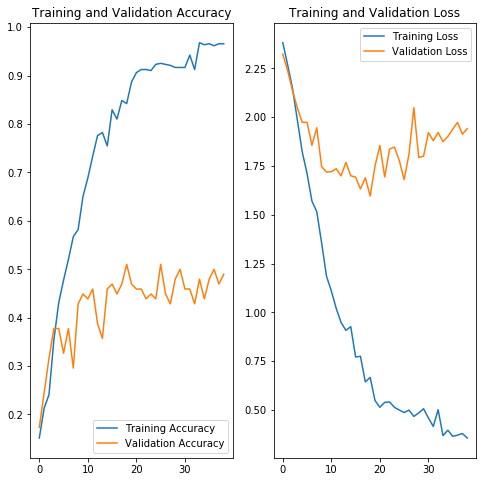

In [84]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [85]:
y_pred_classes = saved_model.predict_classes(x_test)
y_test_classes = []
for y_test_class in y_test:
  y_test_classes.append(np.where(y_test_class == 1)[0][0])

emotions_confusion_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(classification_report(y_test_classes, y_pred_classes, target_names=emotions))

              precision    recall  f1-score   support

       angry       0.60      0.60      0.60        15
        calm       0.55      0.73      0.63        15
     disgust       0.80      0.53      0.64        15
     fearful       0.47      0.47      0.47        15
       happy       0.42      0.53      0.47        15
         sad       0.33      0.33      0.33        15
   surprised       0.36      0.27      0.31        15

    accuracy                           0.50       105
   macro avg       0.50      0.50      0.49       105
weighted avg       0.50      0.50      0.49       105



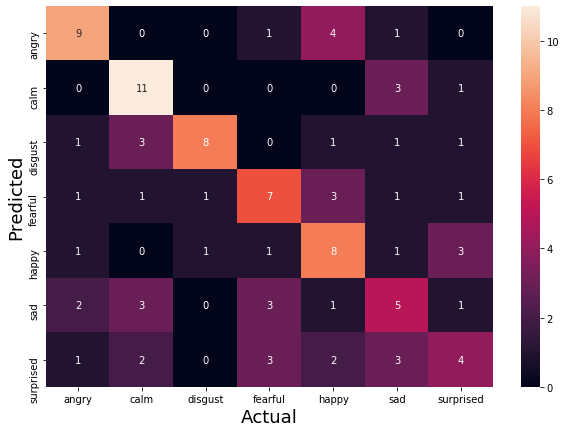

In [86]:
emotion_confusion_df = pd.DataFrame(emotions_confusion_matrix, index = emotions,
                  columns = emotions)
plt.figure(figsize = (10,7))
sn.heatmap(emotion_confusion_df, annot=True)
plt.xlabel('Actual', fontsize=18)
plt.ylabel('Predicted', fontsize=18)
plt.show()